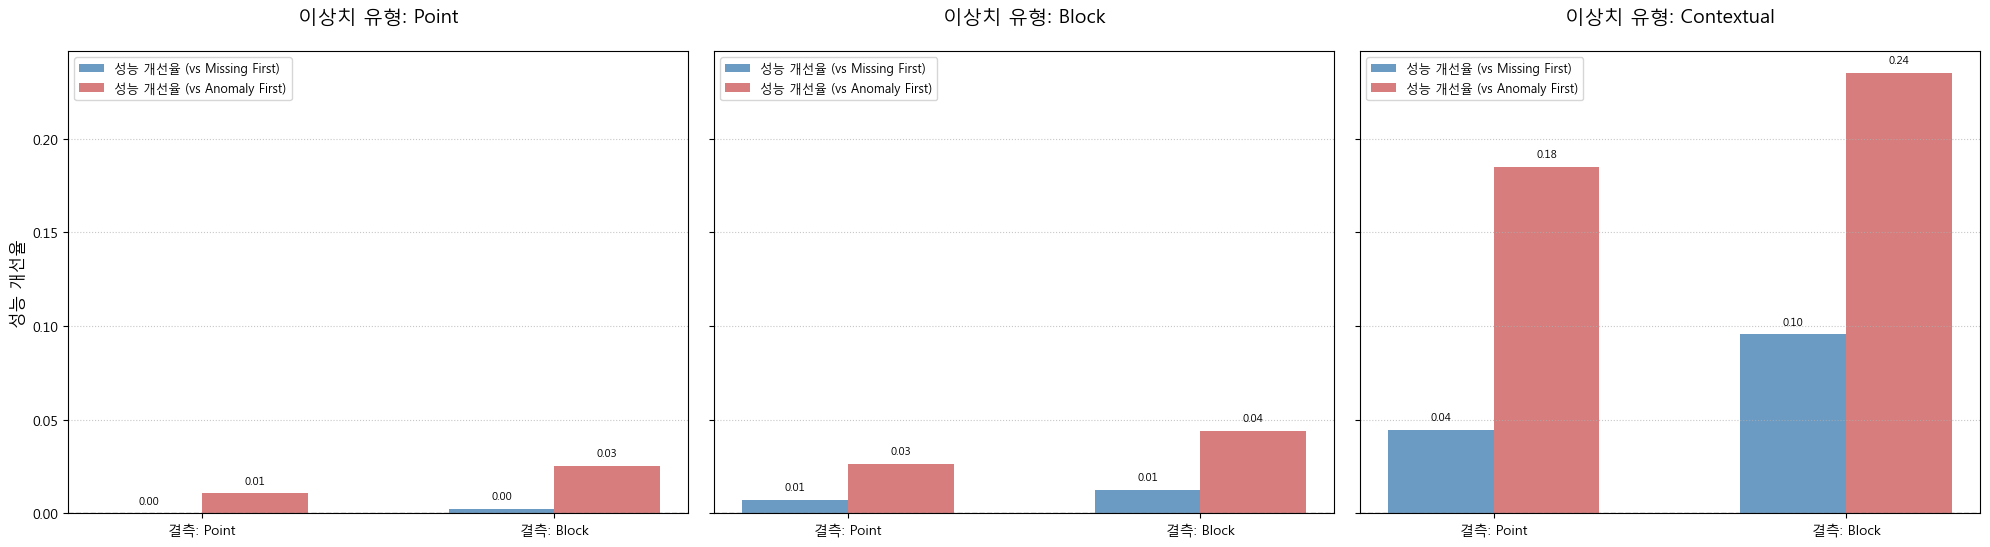

        Combination  Missing First  Anomaly First  Our Method Missing Type  \
0       Point-Point           3.75           3.79        3.75        Point   
1       Point-Block           4.22           4.30        4.19        Point   
2  Point-Contextual          10.07          11.42        9.64        Point   
3       Block-Point           3.92           4.01        3.91        Block   
4       Block-Block           4.81           4.96        4.75        Block   
5  Block-Contextual          11.93          13.45       10.89        Block   

  Anomaly Type  Gap Index (vs Missing First)  Gap Index (vs Anomaly First)  
0        Point                      0.000000                      0.010667  
1        Block                      0.007160                      0.026253  
2   Contextual                      0.044606                      0.184647  
3        Point                      0.002558                      0.025575  
4        Block                      0.012632                      0.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
except RuntimeError:
    try:
        plt.rcParams['font.family'] = 'AppleGothic' # macOS
    except RuntimeError:
        try:
            plt.rcParams['font.family'] = 'NanumGothic' # Linux
        except RuntimeError:
            print("한글 폰트를 찾을 수 없습니다. 그래프의 제목과 축 레이블이 깨질 수 있습니다. 나눔고딕 등 한글 폰트 설치를 권장합니다.")
            plt.rcParams['font.family'] = 'sans-serif' # 기본 대체 폰트

plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# Table 1 Data
data_table1 = {
    'Combination': ['Point-Point', 'Point-Block', 'Point-Contextual',
                    'Block-Point', 'Block-Block', 'Block-Contextual'],
    'Missing First': [3.75, 4.22, 10.07, 3.92, 4.81, 11.93],
    'Anomaly First': [3.79, 4.30, 11.42, 4.01, 4.96, 13.45],
    'Our Method': [3.75, 4.19, 9.64, 3.91, 4.75, 10.89]
}
df_table1 = pd.DataFrame(data_table1)

# Combination을 Missing Type과 Anomaly Type으로 분리
df_table1[['Missing Type', 'Anomaly Type']] = df_table1['Combination'].str.split('-', expand=True)

# *** 추가: Missing Type 순서 지정을 위해 Categorical 타입으로 변환 ***
df_table1['Missing Type'] = pd.Categorical(df_table1['Missing Type'], categories=['Point', 'Block'], ordered=True)


# 수정된 성능 갭 인덱스 계산 함수
def calculate_performance_gap_index(model_mae, baseline_mae):
    model_mae_s = pd.Series(model_mae) if not isinstance(model_mae, pd.Series) else model_mae.copy()
    baseline_mae_s = pd.Series(baseline_mae) if not isinstance(baseline_mae, pd.Series) else baseline_mae.copy()

    gap_index = np.full_like(model_mae_s, np.nan, dtype=float)

    non_zero_mask = (model_mae_s != 0)
    gap_index[non_zero_mask] = (baseline_mae_s[non_zero_mask] - model_mae_s[non_zero_mask]) / model_mae_s[non_zero_mask]

    zero_model_zero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s == 0)
    gap_index[zero_model_zero_baseline_mask] = 0

    zero_model_nonzero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s != 0)
    gap_index[zero_model_nonzero_baseline_mask] = np.inf

    return gap_index

# 표 1에 대한 성능 갭 인덱스 계산
df_table1['Gap Index (vs Missing First)'] = calculate_performance_gap_index(df_table1['Our Method'], df_table1['Missing First'])
df_table1['Gap Index (vs Anomaly First)'] = calculate_performance_gap_index(df_table1['Our Method'], df_table1['Anomaly First'])


# 서브플롯 생성
anomaly_types = ['Point', 'Block', 'Contextual']
# *** 수정: figsize 가로 줄임 ***
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True) # figsize 조정

# autolabel 함수 (서브플롯에 맞게 수정)
def autolabel_subplot(rects, ax_subplot):
    for rect in rects:
        height = rect.get_height()
        label_text = f'{height:.2f}' if np.isfinite(height) else ('∞' if height > 0 else ('-∞' if height < 0 else 'NaN'))

        ax_subplot.annotate(label_text,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5 if height >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

for i, anomaly_type in enumerate(anomaly_types):
    ax = axes[i]
    # 해당 이상치 종류에 대한 데이터 필터링
    df_subset = df_table1[df_table1['Anomaly Type'] == anomaly_type].copy()
    # *** 수정: Categorical 순서대로 정렬됨 (Point -> Block) ***
    df_subset = df_subset.sort_values(by='Missing Type') # ascending=True (기본값) 또는 생략

    labels = [f"결측: {mt}" for mt in df_subset['Missing Type']]
    gap_vs_missing_first = df_subset['Gap Index (vs Missing First)']
    gap_vs_anomaly_first = df_subset['Gap Index (vs Anomaly First)']

    x = np.arange(len(labels))
    # *** 수정: 막대 너비 줄임 ***
    width = 0.3 # 막대 너비 조정

    # 스타일 적용 및 레이블 수정
    rects1 = ax.bar(x - width/2, gap_vs_missing_first, width,
                    label='성능 개선율 (vs Missing First)', # 각 서브플롯에 동일 레이블 적용
                    color='steelblue', alpha=0.8)
    rects2 = ax.bar(x + width/2, gap_vs_anomaly_first, width,
                    label='성능 개선율 (vs Anomaly First)', # 각 서브플롯에 동일 레이블 적용
                    color='indianred', alpha=0.8)

    if i == 0:
        ax.set_ylabel('성능 개선율', fontsize=12) # Y축 레이블 (사용자 코드 반영)
    ax.set_title(f'이상치 유형: {anomaly_type}', fontsize=14, pad=20) # pad 값 조정으로 범례와 제목 간 간격 확보
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=10)
    ax.axhline(0, color='grey', lw=1.0, linestyle='--')
    ax.grid(axis='y', linestyle=':', alpha=0.7)

    autolabel_subplot(rects1, ax)
    autolabel_subplot(rects2, ax)

    # 각 서브플롯의 상단 왼쪽에 범례 추가
    ax.legend(loc='upper left', fontsize=9)

# fig.suptitle('이상치/결측치 유형별 모델 성능 개선율', fontsize=16, y=1.03) # 주석 처리된 부분 유지

# 기존 fig.legend 관련 라인 주석 처리 또는 삭제
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)

# *** 수정: w_pad를 추가하여 서브플롯 간 가로 간격을 약간 줄일 수 있습니다 (선택 사항) ***
# fig.tight_layout(rect=[0, 0, 1, 0.93]) # 기본 tight_layout
fig.tight_layout(rect=[0, 0, 1, 0.93], w_pad=1.5) # w_pad로 서브플롯 간 가로 패딩 조정

plt.show()

# 원본 데이터 프레임 확인 (분리된 컬럼 및 Categorical 타입 확인)
print(df_table1)
print(df_table1.info())

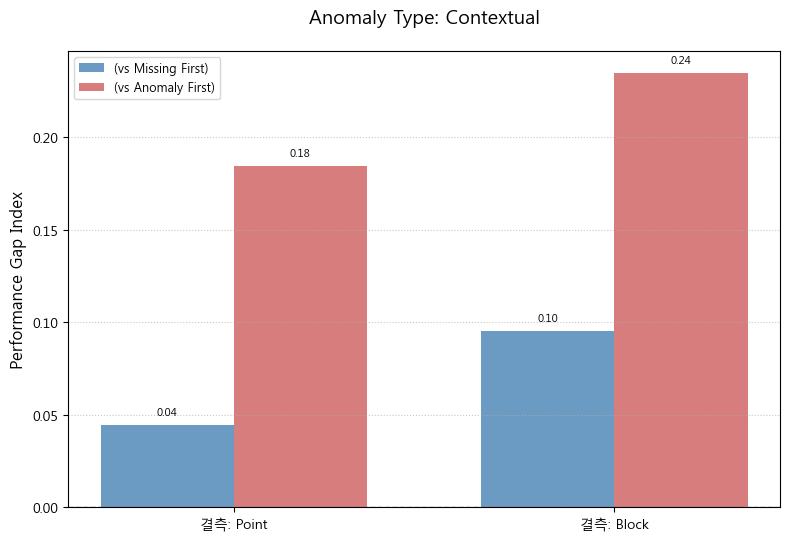

        Combination  Missing First  Anomaly First  Our Method Missing Type  \
0       Point-Point           3.75           3.79        3.75        Point   
1       Point-Block           4.22           4.30        4.19        Point   
2  Point-Contextual          10.07          11.42        9.64        Point   
3       Block-Point           3.92           4.01        3.91        Block   
4       Block-Block           4.81           4.96        4.75        Block   
5  Block-Contextual          11.93          13.45       10.89        Block   

  Anomaly Type  Gap Index (vs Missing First)  Gap Index (vs Anomaly First)  
0        Point                      0.000000                      0.010667  
1        Block                      0.007160                      0.026253  
2   Contextual                      0.044606                      0.184647  
3        Point                      0.002558                      0.025575  
4        Block                      0.012632                      0.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
except RuntimeError:
    try:
        plt.rcParams['font.family'] = 'AppleGothic' # macOS
    except RuntimeError:
        try:
            plt.rcParams['font.family'] = 'NanumGothic' # Linux
        except RuntimeError:
            print("한글 폰트를 찾을 수 없습니다. 그래프의 제목과 축 레이블이 깨질 수 있습니다. 나눔고딕 등 한글 폰트 설치를 권장합니다.")
            plt.rcParams['font.family'] = 'sans-serif' # 기본 대체 폰트

plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# Table 1 Data
data_table1 = {
    'Combination': ['Point-Point', 'Point-Block', 'Point-Contextual',
                    'Block-Point', 'Block-Block', 'Block-Contextual'],
    'Missing First': [3.75, 4.22, 10.07, 3.92, 4.81, 11.93],
    'Anomaly First': [3.79, 4.30, 11.42, 4.01, 4.96, 13.45],
    'Our Method': [3.75, 4.19, 9.64, 3.91, 4.75, 10.89]
}
df_table1 = pd.DataFrame(data_table1)

# Combination을 Missing Type과 Anomaly Type으로 분리
df_table1[['Missing Type', 'Anomaly Type']] = df_table1['Combination'].str.split('-', expand=True)

# *** 추가: Missing Type 순서 지정을 위해 Categorical 타입으로 변환 ***
df_table1['Missing Type'] = pd.Categorical(df_table1['Missing Type'], categories=['Point', 'Block'], ordered=True)


# 수정된 성능 갭 인덱스 계산 함수
def calculate_performance_gap_index(model_mae, baseline_mae):
    model_mae_s = pd.Series(model_mae) if not isinstance(model_mae, pd.Series) else model_mae.copy()
    baseline_mae_s = pd.Series(baseline_mae) if not isinstance(baseline_mae, pd.Series) else baseline_mae.copy()

    gap_index = np.full_like(model_mae_s, np.nan, dtype=float)

    non_zero_mask = (model_mae_s != 0)
    gap_index[non_zero_mask] = (baseline_mae_s[non_zero_mask] - model_mae_s[non_zero_mask]) / model_mae_s[non_zero_mask]

    zero_model_zero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s == 0)
    gap_index[zero_model_zero_baseline_mask] = 0

    zero_model_nonzero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s != 0)
    gap_index[zero_model_nonzero_baseline_mask] = np.inf

    return gap_index

# 표 1에 대한 성능 갭 인덱스 계산
df_table1['Gap Index (vs Missing First)'] = calculate_performance_gap_index(df_table1['Our Method'], df_table1['Missing First'])
df_table1['Gap Index (vs Anomaly First)'] = calculate_performance_gap_index(df_table1['Our Method'], df_table1['Anomaly First'])


# autolabel 함수 (단일 서브플롯용으로도 사용 가능)
def autolabel_subplot(rects, ax_subplot):
    for rect in rects:
        height = rect.get_height()
        label_text = f'{height:.2f}' if np.isfinite(height) else ('∞' if height > 0 else ('-∞' if height < 0 else 'NaN'))

        ax_subplot.annotate(label_text,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5 if height >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# --- 단일 플롯 생성 시작 ---
# 대상 이상치 유형 설정
target_anomaly_type = 'Contextual'

# 단일 서브플롯 생성 (figsize 조정, sharey 제거)
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) # figsize는 필요에 따라 조절

# 해당 이상치 종류에 대한 데이터 필터링
df_subset = df_table1[df_table1['Anomaly Type'] == target_anomaly_type].copy()
# Categorical 순서대로 정렬됨 (Point -> Block)
df_subset = df_subset.sort_values(by='Missing Type')

labels = [f"결측: {mt}" for mt in df_subset['Missing Type']]
gap_vs_missing_first = df_subset['Gap Index (vs Missing First)']
gap_vs_anomaly_first = df_subset['Gap Index (vs Anomaly First)']

x = np.arange(len(labels))
width = 0.35 # 막대 너비 (필요시 조정)

# 스타일 적용 및 레이블 수정
rects1 = ax.bar(x - width/2, gap_vs_missing_first, width,
                label='(vs Missing First)',
                color='steelblue', alpha=0.8)
rects2 = ax.bar(x + width/2, gap_vs_anomaly_first, width,
                label='(vs Anomaly First)',
                color='indianred', alpha=0.8)

# Y축 레이블 항상 표시
ax.set_ylabel('Performance Gap Index', fontsize=12)
ax.set_title(f'Anomaly Type: {target_anomaly_type}', fontsize=14, pad=20) # 제목에 추가 정보
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=10)
ax.axhline(0, color='grey', lw=1.0, linestyle='--')
ax.grid(axis='y', linestyle=':', alpha=0.7)

autolabel_subplot(rects1, ax)
autolabel_subplot(rects2, ax)

# 단일 서브플롯의 상단 왼쪽에 범례 추가
ax.legend(loc='upper left', fontsize=9)

# Figure 전체 제목 (필요하다면 사용, 여기서는 ax.set_title에 통합)
# fig.suptitle('이상치/결측치 유형별 모델 성능 개선율', fontsize=16, y=1.03)

# tight_layout (w_pad 제거)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # rect는 필요에 따라 조정 (아래쪽 여백 약간 확보)

plt.show()
# --- 단일 플롯 생성 끝 ---

# 원본 데이터 프레임 확인 (분리된 컬럼 및 Categorical 타입 확인)
print(df_table1)
print(df_table1.info())

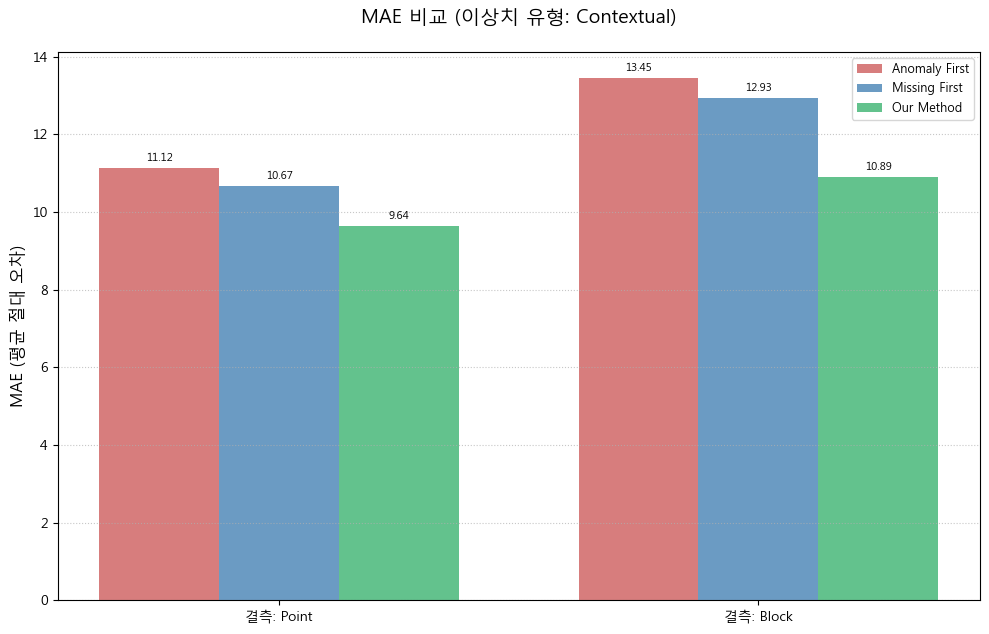

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
except RuntimeError:
    try:
        plt.rcParams['font.family'] = 'AppleGothic' # macOS
    except RuntimeError:
        try:
            plt.rcParams['font.family'] = 'NanumGothic' # Linux
        except RuntimeError:
            print("한글 폰트를 찾을 수 없습니다. 그래프의 제목과 축 레이블이 깨질 수 있습니다. 나눔고딕 등 한글 폰트 설치를 권장합니다.")
            plt.rcParams['font.family'] = 'sans-serif' # 기본 대체 폰트

plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# Table 1 Data
data_table1 = {
    'Combination': ['Point-Point', 'Point-Block', 'Point-Contextual',
                    'Block-Point', 'Block-Block', 'Block-Contextual'],
    'Missing First': [3.73, 4.19, 10.67, 3.91, 4.75, 12.93],
    'Anomaly First': [3.79, 4.30, 11.42, 4.01, 4.96, 13.45],
    'Our Method': [3.75, 4.21, 9.64, 3.95, 4.78, 10.89]
}
df_table1 = pd.DataFrame(data_table1)

# Combination을 Missing Type과 Anomaly Type으로 분리
df_table1[['Missing Type', 'Anomaly Type']] = df_table1['Combination'].str.split('-', expand=True)

# *** 추가: Missing Type 순서 지정을 위해 Categorical 타입으로 변환 ***
df_table1['Missing Type'] = pd.Categorical(df_table1['Missing Type'], categories=['Point', 'Block'], ordered=True)


# autolabel 함수 (단일 서브플롯용으로도 사용 가능)
def autolabel_subplot(rects, ax_subplot):
    for rect in rects:
        height = rect.get_height()
        label_text = f'{height:.2f}' # MAE 값은 소수점 둘째 자리까지 표시

        ax_subplot.annotate(label_text,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), # 텍스트 위치 살짝 위로
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# --- MAE 값 비교 막대 그래프 생성 시작 ---
# 대상 이상치 유형 설정
target_anomaly_type = 'Contextual'

# 단일 서브플롯 생성
fig, ax = plt.subplots(1, 1, figsize=(10, 7)) # figsize는 필요에 따라 조절

# 해당 이상치 종류에 대한 데이터 필터링
df_subset = df_table1[df_table1['Anomaly Type'] == target_anomaly_type].copy()
# Categorical 순서대로 정렬됨 (Point -> Block)
df_subset = df_subset.sort_values(by='Missing Type')

labels = [f"결측: {mt}" for mt in df_subset['Missing Type']]
mae_anomaly_first = df_subset['Anomaly First']
mae_missing_first = df_subset['Missing First']
mae_our_method = df_subset['Our Method']

x = np.arange(len(labels))
bar_width = 0.25 # 막대 너비

# MAE 값으로 막대 그래프 생성 (순서 및 색상 변경)
# 1. Anomaly First (indianred)
rects1 = ax.bar(x - bar_width, mae_anomaly_first, bar_width,
                label='Anomaly First',
                color='indianred', alpha=0.8)
# 2. Missing First (steelblue)
rects2 = ax.bar(x, mae_missing_first, bar_width,
                label='Missing First',
                color='steelblue', alpha=0.8)
# 3. Our Method (mediumseagreen - 어울리는 색상)
rects3 = ax.bar(x + bar_width, mae_our_method, bar_width,
                label='Our Method',
                color='mediumseagreen', alpha=0.8)

# Y축 레이블 및 제목 설정
ax.set_ylabel('MAE (평균 절대 오차)', fontsize=12) # Y축 레이블 명확화
ax.set_title(f'MAE 비교 (이상치 유형: {target_anomaly_type})', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=10)
ax.grid(axis='y', linestyle=':', alpha=0.7)
# ax.axhline(0, color='grey', lw=0.8) # Y축이 0에서 시작하지 않으면 이 선은 오해를 줄 수 있으므로 주석 처리 또는 제거

# # --- Y축 범위 동적 조정 시작 ---
# # 모든 MAE 값을 하나의 시리즈로 합쳐 최소/최대값 계산
# all_mae_values_in_plot = pd.concat([mae_anomaly_first, mae_missing_first, mae_our_method])
# min_val = all_mae_values_in_plot.min()
# max_val = all_mae_values_in_plot.max()

# # Y축 범위에 약간의 여유를 줌 (예: 최소값의 90% ~ 최대값의 110%)
# # 또는 값의 범위에 따라 고정된 패딩을 줄 수도 있습니다.
# # 여기서는 값의 범위가 좁으므로, 최소값에서 조금 빼고 최대값에 조금 더하는 방식을 사용합니다.
# y_bottom_limit = min_val - (max_val - min_val) * 0.2 # 데이터 범위의 20%만큼 아래로 여유
# y_top_limit = max_val + (max_val - min_val) * 0.2    # 데이터 범위의 20%만큼 위로 여유

# # 만약 min_val과 max_val이 거의 같다면 (즉, 데이터 범위가 0에 가깝다면)
# # y_bottom_limit과 y_top_limit이 거의 같아질 수 있으므로, 최소한의 간격을 보장합니다.
# if y_top_limit - y_bottom_limit < 0.5: # 최소 간격 0.5 (데이터 스케일에 따라 조정)
#     y_bottom_limit = min_val - 0.25
#     y_top_limit = max_val + 0.25


# # Y축 하한이 0보다 작아지는 것을 방지 (MAE는 항상 0 이상)
# y_bottom_limit = max(0, y_bottom_limit)


# ax.set_ylim([y_bottom_limit, y_top_limit])
# --- Y축 범위 동적 조정 끝 ---


# 각 막대에 값 표시
autolabel_subplot(rects1, ax)
autolabel_subplot(rects2, ax)
autolabel_subplot(rects3, ax)

# 범례 추가
ax.legend(loc='upper right', fontsize=9) # 범례 위치 및 크기 조정

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# --- MAE 값 비교 막대 그래프 생성 끝 ---

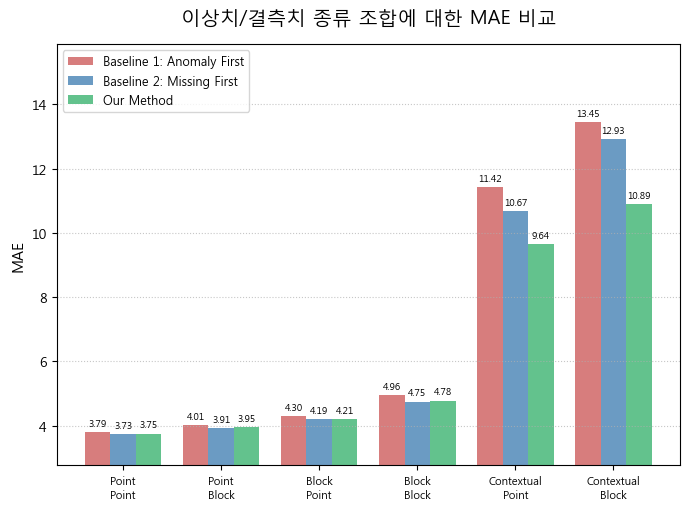

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
except RuntimeError:
    try:
        plt.rcParams['font.family'] = 'AppleGothic' # macOS
    except RuntimeError:
        try:
            plt.rcParams['font.family'] = 'NanumGothic' # Linux
        except RuntimeError:
            print("한글 폰트를 찾을 수 없습니다. 그래프의 제목과 축 레이블이 깨질 수 있습니다. 나눔고딕 등 한글 폰트 설치를 권장합니다.")
            plt.rcParams['font.family'] = 'sans-serif' # 기본 대체 폰트

plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# Table 1 Data
data_table1 = {
    'Combination': ['Point-Point', 'Point-Block', 'Point-Contextual',
                    'Block-Point', 'Block-Block', 'Block-Contextual'],
    'Missing First': [3.73, 4.19, 10.67, 3.91, 4.75, 12.93],
    'Anomaly First': [3.79, 4.30, 11.42, 4.01, 4.96, 13.45],
    'Our Method': [3.75, 4.21, 9.64, 3.95, 4.78, 10.89]
}
df_table1 = pd.DataFrame(data_table1)

# Combination을 Missing Type과 Anomaly Type으로 분리
df_table1[['Missing Type', 'Anomaly Type']] = df_table1['Combination'].str.split('-', expand=True)

# Missing Type 순서 지정을 위해 Categorical 타입으로 변환
df_table1['Missing Type'] = pd.Categorical(df_table1['Missing Type'], categories=['Point', 'Block'], ordered=True)
# Anomaly Type 순서 지정을 위해 Categorical 타입으로 변환
df_table1['Anomaly Type'] = pd.Categorical(df_table1['Anomaly Type'], categories=['Point', 'Block', 'Contextual'], ordered=True)

# 데이터 정렬: Anomaly Type 우선 (Point -> Block -> Contextual), 그 다음 Missing Type (Point -> Block)
df_plot_data = df_table1.sort_values(by=['Anomaly Type', 'Missing Type'])

# autolabel 함수
def autolabel_subplot(rects, ax_subplot):
    for rect in rects:
        height = rect.get_height()
        label_text = f'{height:.2f}'

        ax_subplot.annotate(label_text,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)

# --- MAE 값 비교 막대 그래프 생성 시작 ---
fig, ax = plt.subplots(1, 1, figsize=(7, 6)) # figsize는 (7,7) 유지

# X축 레이블 생성
labels = [f"{row['Anomaly Type']}\n{row['Missing Type']}" for index, row in df_plot_data.iterrows()]

mae_anomaly_first = df_plot_data['Anomaly First'].values
mae_missing_first = df_plot_data['Missing First'].values
mae_our_method = df_plot_data['Our Method'].values

x = np.arange(len(labels)) 
bar_width = 0.26 # 막대 너비 증가 (0.10 -> 0.22) 하여 그룹 간 간격 줄임

# MAE 값으로 막대 그래프 생성
rects1 = ax.bar(x - bar_width, mae_anomaly_first, bar_width,
                label='Baseline 1: Anomaly First',
                color='indianred', alpha=0.8)
rects2 = ax.bar(x, mae_missing_first, bar_width,
                label='Baseline 2: Missing First',
                color='steelblue', alpha=0.8)
rects3 = ax.bar(x + bar_width, mae_our_method, bar_width,
                label='Our Method',
                color='mediumseagreen', alpha=0.8)

# Y축 레이블 및 제목 설정
ax.set_ylabel('MAE', fontsize=11)
ax.set_title('이상치/결측치 종류 조합에 대한 MAE 비교', fontsize=14, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=8) # X축 레이블 폰트 크기 살짝 더 줄임 (9->8)
ax.grid(axis='y', linestyle=':', alpha=0.7)

# --- Y축 범위 동적 조정 시작 ---
all_mae_values_in_plot = np.concatenate([mae_anomaly_first, mae_missing_first, mae_our_method])
min_val = all_mae_values_in_plot.min()
max_val = all_mae_values_in_plot.max()

y_range = max_val - min_val
if y_range == 0:
    y_bottom_limit = min_val - 0.5
    y_top_limit = max_val + 0.5
else:
    y_bottom_limit = min_val - y_range * 0.1
    y_top_limit = max_val + y_range * 0.25 


y_bottom_limit = max(0, y_bottom_limit)

if y_top_limit - y_bottom_limit < 0.5:
    y_bottom_limit = max(0, min_val - 0.25)
    y_top_limit = max_val + 0.25
    if y_top_limit - y_bottom_limit < 0.5 and y_bottom_limit == 0 :
        y_top_limit = y_bottom_limit + 0.5

ax.set_ylim([y_bottom_limit, y_top_limit])
# --- Y축 범위 동적 조정 끝 ---

autolabel_subplot(rects1, ax)
autolabel_subplot(rects2, ax)
autolabel_subplot(rects3, ax)

# 범례를 왼쪽 상단에 추가
ax.legend(loc='upper left', # 위치 변경
          fancybox=True, shadow=False, ncol=1, fontsize=9) # ncol=1로 변경 (세로로 나열)

fig.tight_layout(rect=[0, 0.08, 1, 0.95]) 
plt.show()


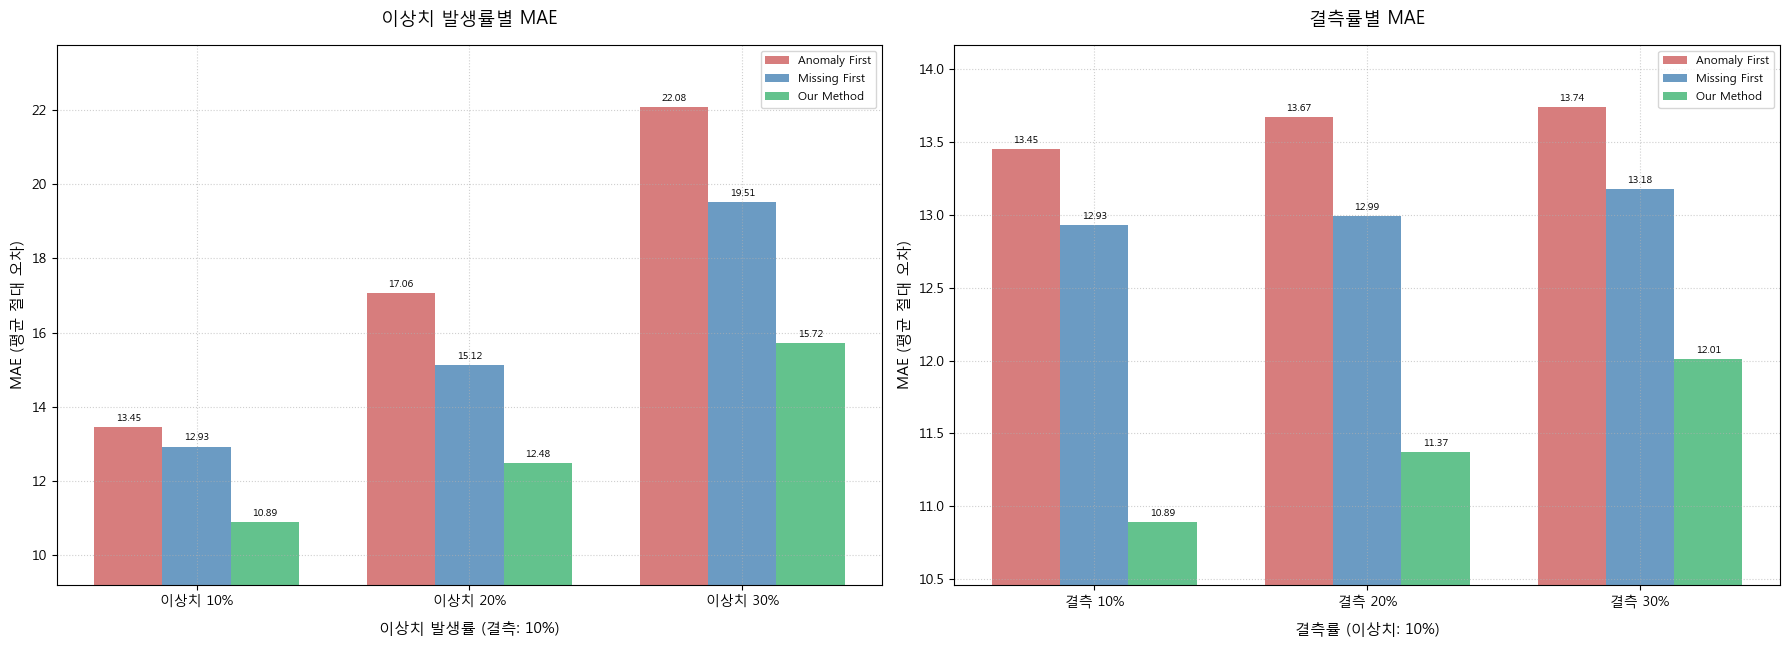


표 2 데이터에 대한 MAE 비교 막대 그래프(Y축 조정)가 생성되었습니다.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
except RuntimeError:
    try:
        plt.rcParams['font.family'] = 'AppleGothic' # macOS
    except RuntimeError:
        try:
            plt.rcParams['font.family'] = 'NanumGothic' # Linux
        except RuntimeError:
            print("한글 폰트를 찾을 수 없습니다. 그래프의 제목과 축 레이블이 깨질 수 있습니다. 나눔고딕 등 한글 폰트 설치를 권장합니다.")
            plt.rcParams['font.family'] = 'sans-serif' # 기본 대체 폰트

plt.rcParams['axes.unicode_minus'] = False

# Table 2 Data
data_table2 = {
    'Rate_Unique': ['10/10_1', '10/20', '10/30',
                    '10/10_2', '20/10', '30/10'],
    'Missing First': [12.93, 15.12, 19.51, 12.93, 12.99, 13.18],
    'Anomaly First': [13.45, 17.06, 22.08, 13.45, 13.67, 13.74],
    'Our Method': [10.89, 12.48, 15.72, 10.89, 11.37, 12.01]
}
df_table2 = pd.DataFrame(data_table2)

# autolabel 함수 (막대 위에 값 표시)
def autolabel_bars(rects_list, ax_subplot, fontsize=7):
    for rect_item_group in rects_list:
        for rect_item in rect_item_group:
            height = rect_item.get_height()
            label_text = f'{height:.2f}'
            ax_subplot.annotate(label_text,
                                xy=(rect_item.get_x() + rect_item.get_width() / 2, height),
                                xytext=(0, 3),  # 텍스트 위치 살짝 위로
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=fontsize)

# --- 표 2 MAE 비교 막대 그래프 (2개 서브플롯) ---
def plot_mae_comparison_subplot(df_subset, x_labels_display, title, ax_to_plot_on, x_axis_label_text):
    mae_anomaly_first = df_subset['Anomaly First']
    mae_missing_first = df_subset['Missing First']
    mae_our_method = df_subset['Our Method']

    x_indices = np.arange(len(x_labels_display))
    bar_width = 0.25  # 각 막대의 너비

    # 막대 그래프 (Anomaly -> Missing -> Our 순서)
    rects1 = ax_to_plot_on.bar(x_indices - bar_width, mae_anomaly_first, bar_width,
                               label='Anomaly First',
                               color='indianred', alpha=0.8)
    rects2 = ax_to_plot_on.bar(x_indices, mae_missing_first, bar_width,
                               label='Missing First',
                               color='steelblue', alpha=0.8)
    rects3 = ax_to_plot_on.bar(x_indices + bar_width, mae_our_method, bar_width,
                               label='Our Method',
                               color='mediumseagreen', alpha=0.8)

    ax_to_plot_on.set_ylabel('MAE (평균 절대 오차)', fontsize=11) # Y축 레이블 명확화
    ax_to_plot_on.set_title(title, fontsize=13, pad=15)
    ax_to_plot_on.set_xticks(x_indices)
    ax_to_plot_on.set_xticklabels(x_labels_display, rotation=0, ha="center", fontsize=10)
    ax_to_plot_on.set_xlabel(x_axis_label_text, fontsize=11, labelpad=10)

    # --- Y축 범위 동적 조정 시작 ---
    all_mae_values_in_plot = pd.concat([mae_anomaly_first, mae_missing_first, mae_our_method])
    min_val = all_mae_values_in_plot.min()
    max_val = all_mae_values_in_plot.max()

    data_range = max_val - min_val
    
    # 데이터 범위에 따라 패딩 설정 (범위가 매우 작으면 절대값 패딩, 아니면 비율 패딩)
    if data_range < 0.5: # 데이터 범위가 0.5 미만일 경우 (값들이 매우 유사)
        y_bottom_limit = min_val - 0.25 # 약간의 절대값 여유
        y_top_limit = max_val + 0.25
    else: # 데이터 범위가 충분할 경우
        y_bottom_limit = min_val - data_range * 0.15 # 데이터 범위의 15%만큼 아래로 여유
        y_top_limit = max_val + data_range * 0.15    # 데이터 범위의 15%만큼 위로 여유

    # Y축 하한이 0보다 작아지는 것을 방지 (MAE는 항상 0 이상)
    y_bottom_limit = max(0, y_bottom_limit)

    # 만약 모든 값이 0이거나, 조정 후 상하한이 같거나 역전되는 경우 방지
    if y_top_limit <= y_bottom_limit:
        y_top_limit = y_bottom_limit + 0.1 # 최소한의 간격 보장

    ax_to_plot_on.set_ylim([y_bottom_limit, y_top_limit])
    # --- Y축 범위 동적 조정 끝 ---

    # 막대 위에 값 표시
    autolabel_bars([rects1, rects2, rects3], ax_to_plot_on, fontsize=7.5)

    ax_to_plot_on.legend(loc='best', fontsize=8.5) # 범례 위치 최적화
    ax_to_plot_on.grid(True, linestyle=':', alpha=0.6)
    # ax_to_plot_on.axhline(0, color='grey', lw=0.8) # Y축이 0에서 시작하지 않을 수 있으므로 주석 처리

# Figure 및 서브플롯 생성
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), sharey=False) # sharey=False로 각자 Y축 스케일

# 서브플롯 1: 이상치 발생률 변화에 따른 MAE
df_subset1 = df_table2.iloc[:3].copy()
x_labels_s1 = ['이상치 10%', '이상치 20%', '이상치 30%']
plot_mae_comparison_subplot(df_subset1, x_labels_s1,
                            '이상치 발생률별 MAE', axes[0], '이상치 발생률 (결측: 10%)')

# 서브플롯 2: 결측률 변화에 따른 MAE
df_subset2 = df_table2.iloc[3:6].copy().reset_index(drop=True)
x_labels_s2 = ['결측 10%', '결측 20%', '결측 30%']
plot_mae_comparison_subplot(df_subset2, x_labels_s2,
                            '결측률별 MAE', axes[1], '결측률 (이상치: 10%)')

# fig.suptitle('표 2: 조건별 MAE 비교', fontsize=16, y=1.02) # 전체 제목은 필요시 추가
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # rect 조정으로 여백 확보 (상단 여백 약간 늘림)
plt.show()

print("\n표 2 데이터에 대한 MAE 비교 막대 그래프(Y축 조정)가 생성되었습니다.")

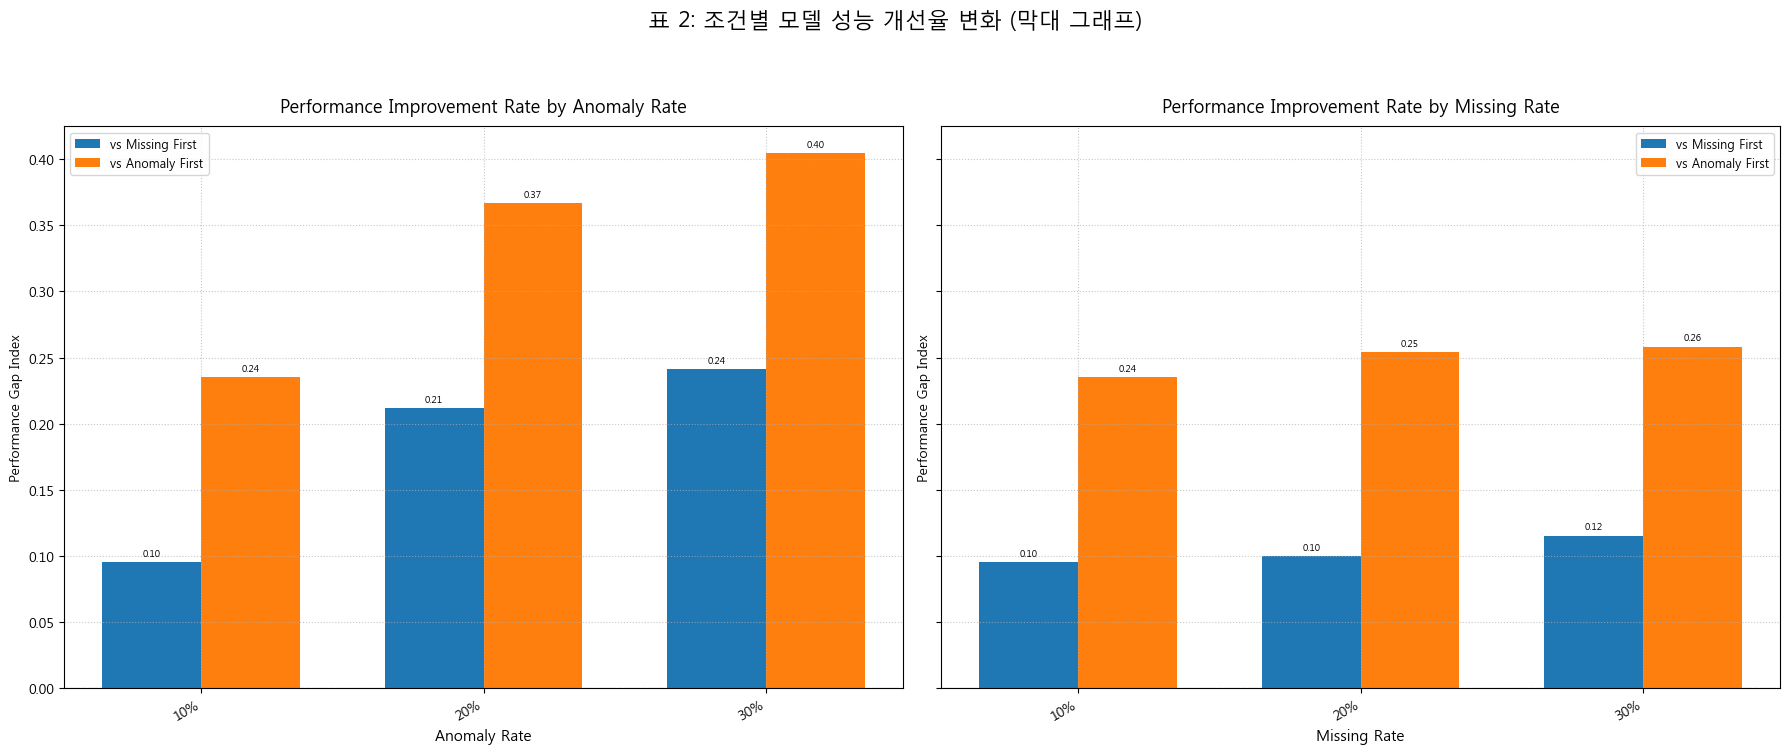


표 2 데이터에 대한 통합 막대 그래프가 생성되었습니다.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# import matplotlib.ticker as mticker # 막대그래프에서는 직접적인 포매터 사용이 덜 일반적

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
except RuntimeError:
    try:
        plt.rcParams['font.family'] = 'AppleGothic' # macOS
    except RuntimeError:
        try:
            plt.rcParams['font.family'] = 'NanumGothic' # Linux
        except RuntimeError:
            print("한글 폰트를 찾을 수 없습니다. 그래프의 제목과 축 레이블이 깨질 수 있습니다. 나눔고딕 등 한글 폰트 설치를 권장합니다.")
            plt.rcParams['font.family'] = 'sans-serif' # 기본 대체 폰트

plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지


# Table 2 Data
data_table2 = {
    'Rate_Unique': ['10/10_1', '10/20', '10/30', 
                    '10/10_2', '20/10', '30/10'],
    'Missing First': [11.93, 15.12, 19.51, 11.93, 11.99, 12.18],
    'Anomaly First': [13.45, 17.06, 22.08, 13.45, 13.67, 13.74],
    'Our Method': [10.89, 12.48, 15.72, 10.89, 10.90, 10.92]
}
df_table2 = pd.DataFrame(data_table2)

# 성능 개선율 계산 함수
def calculate_performance_improvement_rate(model_mae, baseline_mae):
    model_mae_s = pd.Series(model_mae) if not isinstance(model_mae, pd.Series) else model_mae.copy()
    baseline_mae_s = pd.Series(baseline_mae) if not isinstance(baseline_mae, pd.Series) else baseline_mae.copy()
    improvement_rate = np.full_like(model_mae_s, np.nan, dtype=float)
    non_zero_mask = (model_mae_s != 0)
    improvement_rate[non_zero_mask] = (baseline_mae_s[non_zero_mask] - model_mae_s[non_zero_mask]) / model_mae_s[non_zero_mask]
    zero_model_zero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s == 0)
    improvement_rate[zero_model_zero_baseline_mask] = 0
    zero_model_nonzero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s != 0)
    improvement_rate[zero_model_nonzero_baseline_mask] = np.inf
    return improvement_rate

col_impr_vs_missing = 'Improvement Rate (vs Missing First)'
col_impr_vs_anomaly = 'Improvement Rate (vs Anomaly First)'

df_table2[col_impr_vs_missing] = calculate_performance_improvement_rate(df_table2['Our Method'], df_table2['Missing First'])
df_table2[col_impr_vs_anomaly] = calculate_performance_improvement_rate(df_table2['Our Method'], df_table2['Anomaly First'])

# --- 표 1 성능 개선율 막대 그래프 (기존 함수 재활용) ---
def plot_single_bar_chart(df, x_col_name_internal_df_key, title, x_labels_display_list, ax_to_plot_on=None):
    # 이 함수는 이제 ax_to_plot_on 인자를 받아 특정 subplot에 그릴 수 있도록 수정될 수 있으나,
    # 현재 요청은 표2에 대한 것이므로, 표1 그래프는 이전처럼 단독으로 생성.
    # 만약 표1도 서브플롯의 일부로 넣고 싶다면 이 함수를 수정하거나 별도 로직 필요.

    labels = x_labels_display_list
    data_col1 = df[col_impr_vs_missing]
    data_col2 = df[col_impr_vs_anomaly]
    
    x_indices = np.arange(len(labels))
    width = 0.35

    if ax_to_plot_on is None: # 단독 그래프 생성
        fig, current_ax = plt.subplots(figsize=(14, 7))
    else: # 제공된 subplot ax에 그림
        current_ax = ax_to_plot_on

    rects1 = current_ax.bar(x_indices - width/2, data_col1, width, label='vs Missing First')
    rects2 = current_ax.bar(x_indices + width/2, data_col2, width, label='vs Anomaly First')

    current_ax.set_ylabel('Performance Gap Index')
    current_ax.set_title(title, fontsize=13 if ax_to_plot_on else 15, pad=10 if ax_to_plot_on else 20)
    current_ax.set_xticks(x_indices)
    current_ax.set_xticklabels(labels, rotation=30, ha="right", fontsize=10)
    current_ax.legend(fontsize=9 if ax_to_plot_on else 10, loc='best') # 서브플롯일 경우 범례 폰트 약간 줄임
    current_ax.axhline(0, color='grey', lw=0.8, linestyle='--')
    
    def autolabel_bars(rects_list, on_ax):
        for rect_item in rects_list:
            height = rect_item.get_height()
            label_text = f'{height:.2f}' if np.isfinite(height) else ('∞' if height > 0 else ('-∞' if height < 0 else 'NaN'))
            on_ax.annotate(label_text, xy=(rect_item.get_x() + rect_item.get_width() / 2, height),
                        xytext=(0, 3 if height >= 0 else -12), textcoords="offset points", # 텍스트 위치 조정
                        ha='center', va='bottom', fontsize=7 if ax_to_plot_on else 8) # 서브플롯일 경우 폰트 약간 줄임
    autolabel_bars(rects1, current_ax)
    autolabel_bars(rects2, current_ax)

    current_ax.grid(True, linestyle=':', alpha=0.7)
    if ax_to_plot_on is None: # 단독 그래프일 경우에만 tight_layout 및 show
        plt.tight_layout()
        plt.show()

# --- 표 2 성능 개선율 막대 그래프 (2개 서브플롯으로 통합) ---
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7.5), sharey=True) # 1행 2열, Y축 공유

# 서브플롯 1: 결측률 10% 고정, 이상치율 변화 (10%, 20%, 30%)
df_subset1 = df_table2.iloc[:3].copy()
x_labels_s1 = ['10%', '20%', '30%'] # X축 레이블
ax1 = axes[0]
plot_single_bar_chart(df_subset1, '', # x_col_name_internal_df_key는 단독 그래프용, 여기선 불필요
                      'Performance Improvement Rate by Anomaly Rate', 
                      x_labels_s1, 
                      ax_to_plot_on=ax1)
ax1.set_xlabel('Anomaly Rate', fontsize=11) # 서브플롯용 x축 레이블 설정

# 서브플롯 2: 이상치율 10% 고정, 결측률 변화 (10%, 20%, 30%)
df_subset2_data_points = [df_table2.iloc[3], df_table2.iloc[4], df_table2.iloc[5]]
df_subset2 = pd.DataFrame(df_subset2_data_points).reset_index(drop=True) # 인덱스 리셋 중요
x_labels_s2 = ['10%', '20%', '30%'] # X축 레이블
ax2 = axes[1]
plot_single_bar_chart(df_subset2, '', # x_col_name_internal_df_key는 단독 그래프용, 여기선 불필요
                      'Performance Improvement Rate by Missing Rate', 
                      x_labels_s2, 
                      ax_to_plot_on=ax2)
ax2.set_xlabel('Missing Rate', fontsize=11) # 서브플롯용 x축 레이블 설정

fig.suptitle('표 2: 조건별 모델 성능 개선율 변화 (막대 그래프)', fontsize=16, y=1.00)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # suptitle과의 간격 및 전체 레이아웃 조정
plt.show()

print("\n표 2 데이터에 대한 통합 막대 그래프가 생성되었습니다.")

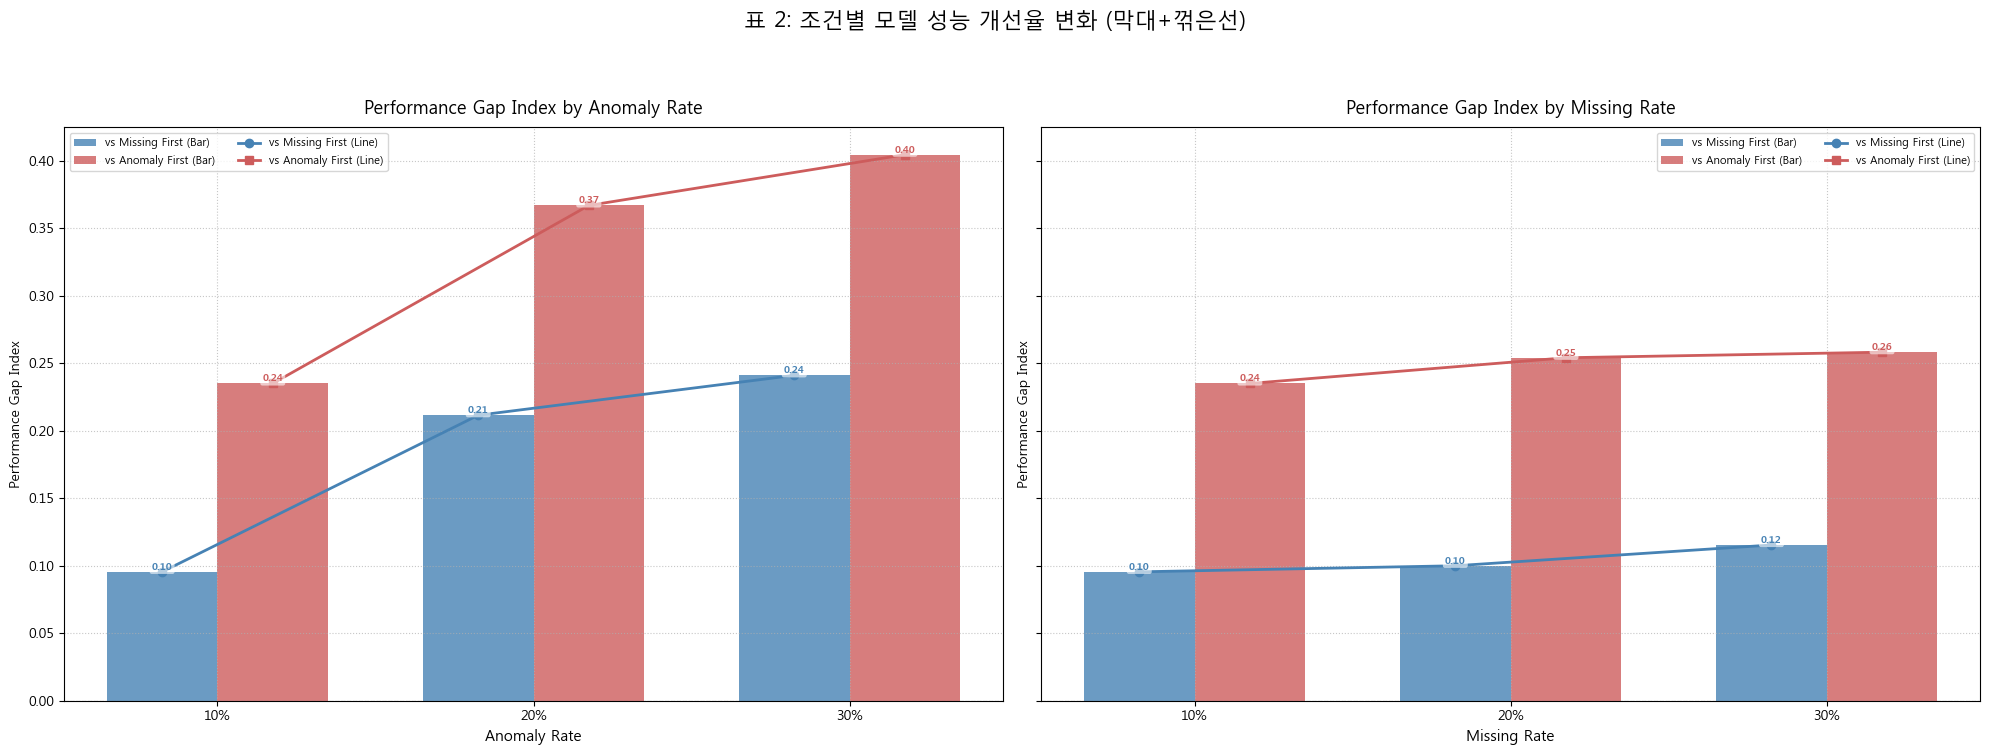


표 2 데이터에 대한 통합 막대+꺾은선 그래프가 생성되었습니다.


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
except RuntimeError:
    try:
        plt.rcParams['font.family'] = 'AppleGothic' # macOS
    except RuntimeError:
        try:
            plt.rcParams['font.family'] = 'NanumGothic' # Linux
        except RuntimeError:
            print("한글 폰트를 찾을 수 없습니다. 그래프의 제목과 축 레이블이 깨질 수 있습니다. 나눔고딕 등 한글 폰트 설치를 권장합니다.")
            plt.rcParams['font.family'] = 'sans-serif' # 기본 대체 폰트

plt.rcParams['axes.unicode_minus'] = False

# Table 2 Data
data_table2 = {
    'Rate_Unique': ['10/10_1', '10/20', '10/30',
                    '10/10_2', '20/10', '30/10'],
    'Missing First': [11.93, 15.12, 19.51, 11.93, 11.99, 12.18],
    'Anomaly First': [13.45, 17.06, 22.08, 13.45, 13.67, 13.74],
    'Our Method': [10.89, 12.48, 15.72, 10.89, 10.90, 10.92]
}
df_table2 = pd.DataFrame(data_table2)

def calculate_performance_improvement_rate(model_mae, baseline_mae):
    model_mae_s = pd.Series(model_mae) if not isinstance(model_mae, pd.Series) else model_mae.copy()
    baseline_mae_s = pd.Series(baseline_mae) if not isinstance(baseline_mae, pd.Series) else baseline_mae.copy()
    improvement_rate = np.full_like(model_mae_s, np.nan, dtype=float)
    non_zero_mask = (model_mae_s != 0)
    improvement_rate[non_zero_mask] = (baseline_mae_s[non_zero_mask] - model_mae_s[non_zero_mask]) / model_mae_s[non_zero_mask]
    zero_model_zero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s == 0)
    improvement_rate[zero_model_zero_baseline_mask] = 0
    zero_model_nonzero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s != 0)
    improvement_rate[zero_model_nonzero_baseline_mask] = np.inf
    return improvement_rate

col_impr_vs_missing = 'Improvement Rate (vs Missing First)'
col_impr_vs_anomaly = 'Improvement Rate (vs Anomaly First)'

df_table2[col_impr_vs_missing] = calculate_performance_improvement_rate(df_table2['Our Method'], df_table2['Missing First'])
df_table2[col_impr_vs_anomaly] = calculate_performance_improvement_rate(df_table2['Our Method'], df_table2['Anomaly First'])

# --- 표 2 성능 개선율 막대 + 꺾은선 그래프 (2개 서브플롯으로 통합) ---
def plot_bar_and_line_subplot(df_subset, x_labels_display, title, ax_to_plot_on, x_axis_label):
    data_col1 = df_subset[col_impr_vs_missing]
    data_col2 = df_subset[col_impr_vs_anomaly]
    
    x_indices = np.arange(len(x_labels_display))
    width = 0.35

    # 막대 그래프
    rects1 = ax_to_plot_on.bar(x_indices - width/2, data_col1, width, color='steelblue', alpha=0.8) # alpha 추가로 선이 더 잘보이게
    rects2 = ax_to_plot_on.bar(x_indices + width/2, data_col2, width, color='indianred', alpha=0.8) # alpha 추가

    # 꺾은선 그래프
    line1 = ax_to_plot_on.plot(x_indices - width/2, data_col1, marker='o', linestyle='-', color='steelblue', linewidth=2) # 선 굵기 조정
    line2 = ax_to_plot_on.plot(x_indices + width/2, data_col2, marker='s', linestyle='-', color='indianred', linewidth=2) # 선 굵기 조정

    # Y축 레이블 수정
    ax_to_plot_on.set_ylabel('Performance Gap Index')
    ax_to_plot_on.set_title(title, fontsize=13, pad=10)
    ax_to_plot_on.set_xticks(x_indices)
    ax_to_plot_on.set_xticklabels(x_labels_display, rotation=0, ha="center", fontsize=10)
    ax_to_plot_on.set_xlabel(x_axis_label, fontsize=11)
    
    handles = [rects1.patches[0], rects2.patches[0], line1[0], line2[0]]
    labels = ['vs Missing First (Bar)', 'vs Anomaly First (Bar)', 
              'vs Missing First (Line)', 'vs Anomaly First (Line)']
    ax_to_plot_on.legend(handles, labels, fontsize=8, loc='best', ncol=2)

    ax_to_plot_on.axhline(0, color='grey', lw=0.8, linestyle='--')
    
    # 막대 위 숫자 출력 제거
    # def autolabel_bars(rects_list, on_ax):
    #     for rect_item in rects_list:
    #         height = rect_item.get_height()
    #         label_text = f'{height:.2f}' if np.isfinite(height) else ('∞' if height > 0 else ('-∞' if height < 0 else 'NaN'))
    #         on_ax.annotate(label_text, xy=(rect_item.get_x() + rect_item.get_width() / 2, height),
    #                     xytext=(0, 3 if height >= 0 else -12), textcoords="offset points",
    #                     ha='center', va='bottom', fontsize=7)
    # autolabel_bars(rects1, ax_to_plot_on)
    # autolabel_bars(rects2, ax_to_plot_on)

    # 꺾은선 그래프에 값 표시
    for line_obj_list, data_series in zip([line1, line2], [data_col1, data_col2]):
        line_obj = line_obj_list[0]
        x_coords = line_obj.get_xdata()
        y_coords = data_series
        for x, y in zip(x_coords, y_coords):
            label_text = f'{y:.2f}' if np.isfinite(y) else ('∞' if y > 0 else ('-∞' if y < 0 else 'NaN'))
            ax_to_plot_on.text(x, y, label_text, ha='center', va='bottom' if y >= 0 else 'top', 
                               fontsize=7.5, color=line_obj.get_color(), fontweight='bold', # 폰트 굵게
                               bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6)) # alpha 약간 조정

    ax_to_plot_on.grid(True, linestyle=':', alpha=0.7)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7.5), sharey=True)

df_subset1 = df_table2.iloc[:3].copy()
x_labels_s1 = ['10%', '20%', '30%']
plot_bar_and_line_subplot(df_subset1, x_labels_s1,
                          'Performance Gap Index by Anomaly Rate', axes[0], 'Anomaly Rate')

df_subset2_data_points = [df_table2.iloc[3], df_table2.iloc[4], df_table2.iloc[5]]
df_subset2 = pd.DataFrame(df_subset2_data_points).reset_index(drop=True)
x_labels_s2 = ['10%', '20%', '30%']
plot_bar_and_line_subplot(df_subset2, x_labels_s2,
                          'Performance Gap Index by Missing Rate', axes[1], 'Missing Rate')

fig.suptitle('표 2: 조건별 모델 성능 개선율 변화 (막대+꺾은선)', fontsize=16, y=1.00)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\n표 2 데이터에 대한 통합 막대+꺾은선 그래프가 생성되었습니다.")

--- df_table2 성능 개선율 계산 결과 (일부) ---
  Rate_Unique  Missing First  Anomaly First  Our Method  \
0       10/10          11.93          13.45       10.90   
1       10/15          15.12          17.06       12.92   
2       10/20          19.51          22.08       13.89   
3       10/25          22.93          26.45       15.48   
4       10/30          28.99          33.67       18.72   

   Improvement Rate (vs Missing First)  Improvement Rate (vs Anomaly First)  \
0                             0.094495                             0.233945   
1                             0.170279                             0.320433   
2                             0.404608                             0.589633   
3                             0.481266                             0.708656   
4                             0.548611                             0.798611   

   Missing Rate  Anomaly Rate  
0            10            10  
1            10            15  
2            10            20  
3     

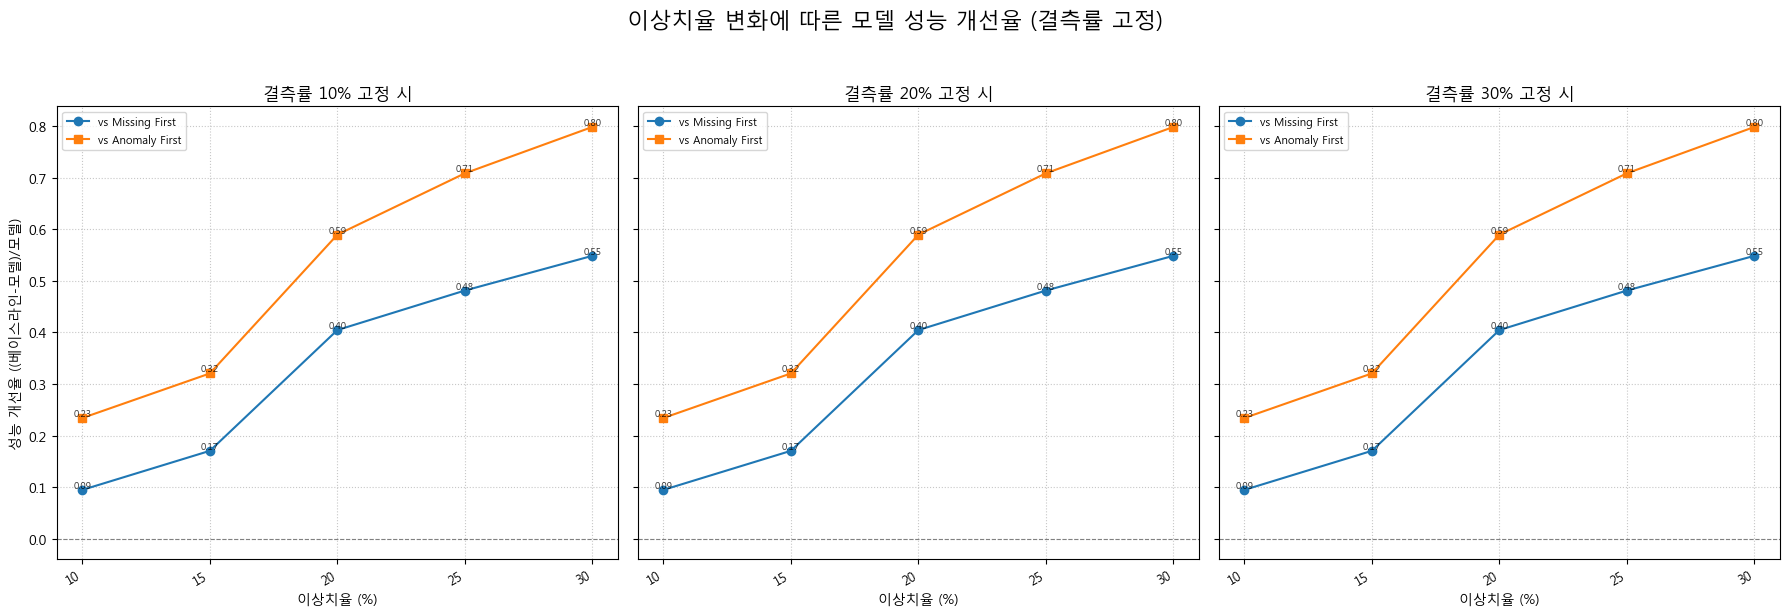


결측률 고정, 이상치율 변화에 따른 성능 개선율 꺾은선 그래프 (통합 이미지)가 생성되었습니다.


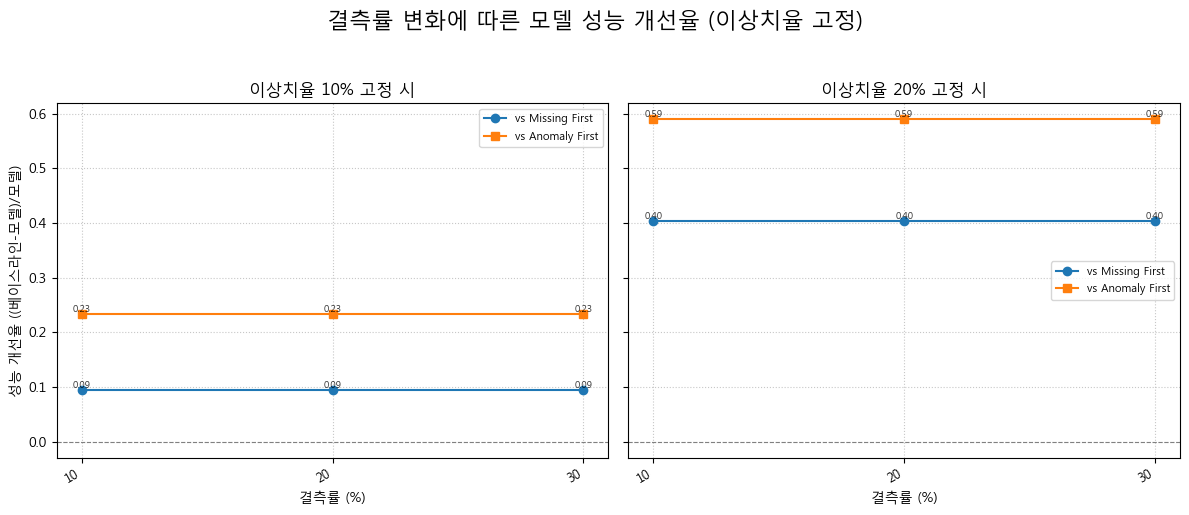


이상치율 고정, 결측률 변화에 따른 성능 개선율 꺾은선 그래프 (통합 이미지 예시)가 생성되었습니다.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker # For custom tick formatting

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
except RuntimeError:
    try:
        plt.rcParams['font.family'] = 'AppleGothic' # macOS
    except RuntimeError:
        try:
            plt.rcParams['font.family'] = 'NanumGothic' # Linux
        except RuntimeError:
            print("한글 폰트를 찾을 수 없습니다. 그래프의 제목과 축 레이블이 깨질 수 있습니다. 나눔고딕 등 한글 폰트 설치를 권장합니다.")
            plt.rcParams['font.family'] = 'sans-serif' # 기본 대체 폰트

plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# --- Table 2 Data ---
data_table2 = {
    'Rate_Unique': ['10/10', '10/15', '10/20', '10/25', '10/30',
                    '20/10', '20/15', '20/20', '20/25', '20/30',
                    '30/10', '30/15', '30/20', '30/25', '30/30'],
    'Missing First': [11.93, 15.12, 19.51, 22.93, 28.99,
                     11.93, 15.12, 19.51, 22.93, 28.99,
                     11.93, 15.12, 19.51, 22.93, 28.99,],
    'Anomaly First': [13.45, 17.06, 22.08, 26.45, 33.67,
                      13.45, 17.06, 22.08, 26.45, 33.67,
                      13.45, 17.06, 22.08, 26.45, 33.67],
    'Our Method':    [10.90, 12.92, 13.89, 15.48, 18.72,
                      10.90, 12.92, 13.89, 15.48, 18.72,
                      10.90, 12.92, 13.89, 15.48, 18.72]
}
df_table2 = pd.DataFrame(data_table2)

# 성능 개선율 계산 함수 (변경 없음)
def calculate_performance_improvement_rate(model_mae, baseline_mae):
    model_mae_s = pd.Series(model_mae) if not isinstance(model_mae, pd.Series) else model_mae.copy()
    baseline_mae_s = pd.Series(baseline_mae) if not isinstance(baseline_mae, pd.Series) else baseline_mae.copy()
    improvement_rate = np.full_like(model_mae_s, np.nan, dtype=float)
    non_zero_mask = (model_mae_s != 0)
    improvement_rate[non_zero_mask] = (baseline_mae_s[non_zero_mask] - model_mae_s[non_zero_mask]) / model_mae_s[non_zero_mask]
    zero_model_zero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s == 0)
    improvement_rate[zero_model_zero_baseline_mask] = 0
    zero_model_nonzero_baseline_mask = (model_mae_s == 0) & (baseline_mae_s != 0)
    improvement_rate[zero_model_nonzero_baseline_mask] = np.inf
    return improvement_rate

col_impr_vs_missing = 'Improvement Rate (vs Missing First)'
col_impr_vs_anomaly = 'Improvement Rate (vs Anomaly First)'
df_table2[col_impr_vs_missing] = calculate_performance_improvement_rate(df_table2['Our Method'], df_table2['Missing First'])
df_table2[col_impr_vs_anomaly] = calculate_performance_improvement_rate(df_table2['Our Method'], df_table2['Anomaly First'])

df_table2[['Missing Rate', 'Anomaly Rate']] = df_table2['Rate_Unique'].str.split('/', expand=True).astype(int)

print("--- df_table2 성능 개선율 계산 결과 (일부) ---")
print(df_table2.head())
print("-" * 30)

# --- 성능 개선율 꺾은선 그래프 (서브플롯으로 통합) ---
# 결측률 고정 (10%, 20%, 30%), 이상치율 변화에 따른 그래프
fixed_missing_rates = [10, 20, 30]
num_subplots = len(fixed_missing_rates)

# 1행 num_subplots열의 서브플롯 생성, 또는 3행 1열 등 원하는 레이아웃으로 변경 가능
# 여기서는 1행 3열로 가정
fig, axes = plt.subplots(nrows=1, ncols=num_subplots, figsize=(18, 6), sharey=True) # sharey=True Y축 공유

if num_subplots == 1: # subplot이 하나일 경우 axes가 배열이 아님
    axes = [axes]

for i, missing_rate_val in enumerate(fixed_missing_rates):
    ax = axes[i] # 현재 서브플롯 선택
    df_subset = df_table2[df_table2['Missing Rate'] == missing_rate_val].copy()

    if df_subset.empty:
        print(f"데이터 없음: 결측률 {missing_rate_val}%")
        ax.text(0.5, 0.5, f'데이터 없음\n결측률 {missing_rate_val}%', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'결측률 {missing_rate_val}% 고정', fontsize=12)
        continue

    x_data = df_subset['Anomaly Rate'] # 이상치율이 x축

    ax.plot(x_data, df_subset[col_impr_vs_missing], label='vs Missing First', marker='o')
    ax.plot(x_data, df_subset[col_impr_vs_anomaly], label='vs Anomaly First', marker='s')

    # 데이터 값 표시
    for col_plot in [col_impr_vs_missing, col_impr_vs_anomaly]:
        for x_coord, y_coord in zip(x_data, df_subset[col_plot]):
            val_text = f'{y_coord:.2f}' if np.isfinite(y_coord) else ('∞' if y_coord > 0 else ('-∞' if y_coord < 0 else 'NaN'))
            ax.text(x_coord, y_coord, val_text, ha='center', va='bottom' if y_coord >=0 else 'top', fontsize=7, alpha=0.8)

    ax.set_title(f'결측률 {missing_rate_val}% 고정 시', fontsize=12)
    ax.set_xlabel('이상치율 (%)', fontsize=10)
    if i == 0: # 첫 번째 서브플롯에만 Y축 레이블 표시
        ax.set_ylabel('성능 개선율 ((베이스라인-모델)/모델)', fontsize=10)
    
    unique_x_ticks = sorted(x_data.unique())
    ax.set_xticks(ticks=unique_x_ticks)
    ax.set_xticklabels([f'{val}' for val in unique_x_ticks], rotation=30, ha="right", fontsize=9) # '%'는 xlabel에 있으므로 생략 가능
    # ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d%%')) # 또는 포매터 사용

    ax.legend(fontsize=8, loc='best')
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.axhline(0, color='grey', lw=0.8, linestyle='--')

# 전체 Figure에 대한 제목 (선택 사항)
fig.suptitle('이상치율 변화에 따른 모델 성능 개선율 (결측률 고정)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # suptitle과의 간격 조절
plt.show()

print("\n결측률 고정, 이상치율 변화에 따른 성능 개선율 꺾은선 그래프 (통합 이미지)가 생성되었습니다.")

# --- 이상치율 고정, 결측률 변화에 따른 그래프 (필요시 별도 이미지로 생성 또는 위와 같이 통합) ---
# 이 부분은 이전 코드와 동일하게 별도의 이미지로 생성하거나, 위와 유사한 방식으로 서브플롯 통합 가능
# 예시: 이상치율 10% 고정
fixed_anomaly_rates_to_plot = [10, 20] # 예시로 2개만 그림
num_subplots_anomaly_fixed = len(fixed_anomaly_rates_to_plot)

if num_subplots_anomaly_fixed > 0:
    fig2, axes2 = plt.subplots(nrows=1, ncols=num_subplots_anomaly_fixed, figsize=(12, 5), sharey=True)
    if num_subplots_anomaly_fixed == 1:
        axes2 = [axes2]

    for i, anomaly_rate_val in enumerate(fixed_anomaly_rates_to_plot):
        ax = axes2[i]
        df_subset_anom = df_table2[df_table2['Anomaly Rate'] == anomaly_rate_val].copy()
        if df_subset_anom.empty:
            print(f"데이터 없음: 이상치율 {anomaly_rate_val}%")
            ax.text(0.5, 0.5, f'데이터 없음\n이상치율 {anomaly_rate_val}%', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'이상치율 {anomaly_rate_val}% 고정', fontsize=12)
            continue
        
        x_data_anom = df_subset_anom['Missing Rate'] # 결측률이 x축

        ax.plot(x_data_anom, df_subset_anom[col_impr_vs_missing], label='vs Missing First', marker='o')
        ax.plot(x_data_anom, df_subset_anom[col_impr_vs_anomaly], label='vs Anomaly First', marker='s')

        for col_plot in [col_impr_vs_missing, col_impr_vs_anomaly]:
             for x_coord, y_coord in zip(x_data_anom, df_subset_anom[col_plot]):
                val_text = f'{y_coord:.2f}' if np.isfinite(y_coord) else ('∞' if y_coord > 0 else ('-∞' if y_coord < 0 else 'NaN'))
                ax.text(x_coord, y_coord, val_text, ha='center', va='bottom' if y_coord >=0 else 'top', fontsize=7, alpha=0.8)

        ax.set_title(f'이상치율 {anomaly_rate_val}% 고정 시', fontsize=12)
        ax.set_xlabel('결측률 (%)', fontsize=10)
        if i == 0:
            ax.set_ylabel('성능 개선율 ((베이스라인-모델)/모델)', fontsize=10)
        
        unique_x_ticks_anom = sorted(x_data_anom.unique())
        ax.set_xticks(ticks=unique_x_ticks_anom)
        ax.set_xticklabels([f'{val}' for val in unique_x_ticks_anom], rotation=30, ha="right", fontsize=9)
        
        ax.legend(fontsize=8, loc='best')
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.axhline(0, color='grey', lw=0.8, linestyle='--')

    fig2.suptitle('결측률 변화에 따른 모델 성능 개선율 (이상치율 고정)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    print("\n이상치율 고정, 결측률 변화에 따른 성능 개선율 꺾은선 그래프 (통합 이미지 예시)가 생성되었습니다.")